# Extended Data Figure 2: Hyperparameter changes on visualization and consistency.

### Temperature has the largest effect on visualization (vs. consistency) of the embedding

- shown by a range from 0.1 to 3.21 (highest consistency for Rat 1), as can be appreciated in 3D (top) and post FastICA into a 2D embedding (middle). Bottom row shows the corresponding change on mean consistency.

- Note, tempature is both a learnable and easily modified parameter in CEBRA.

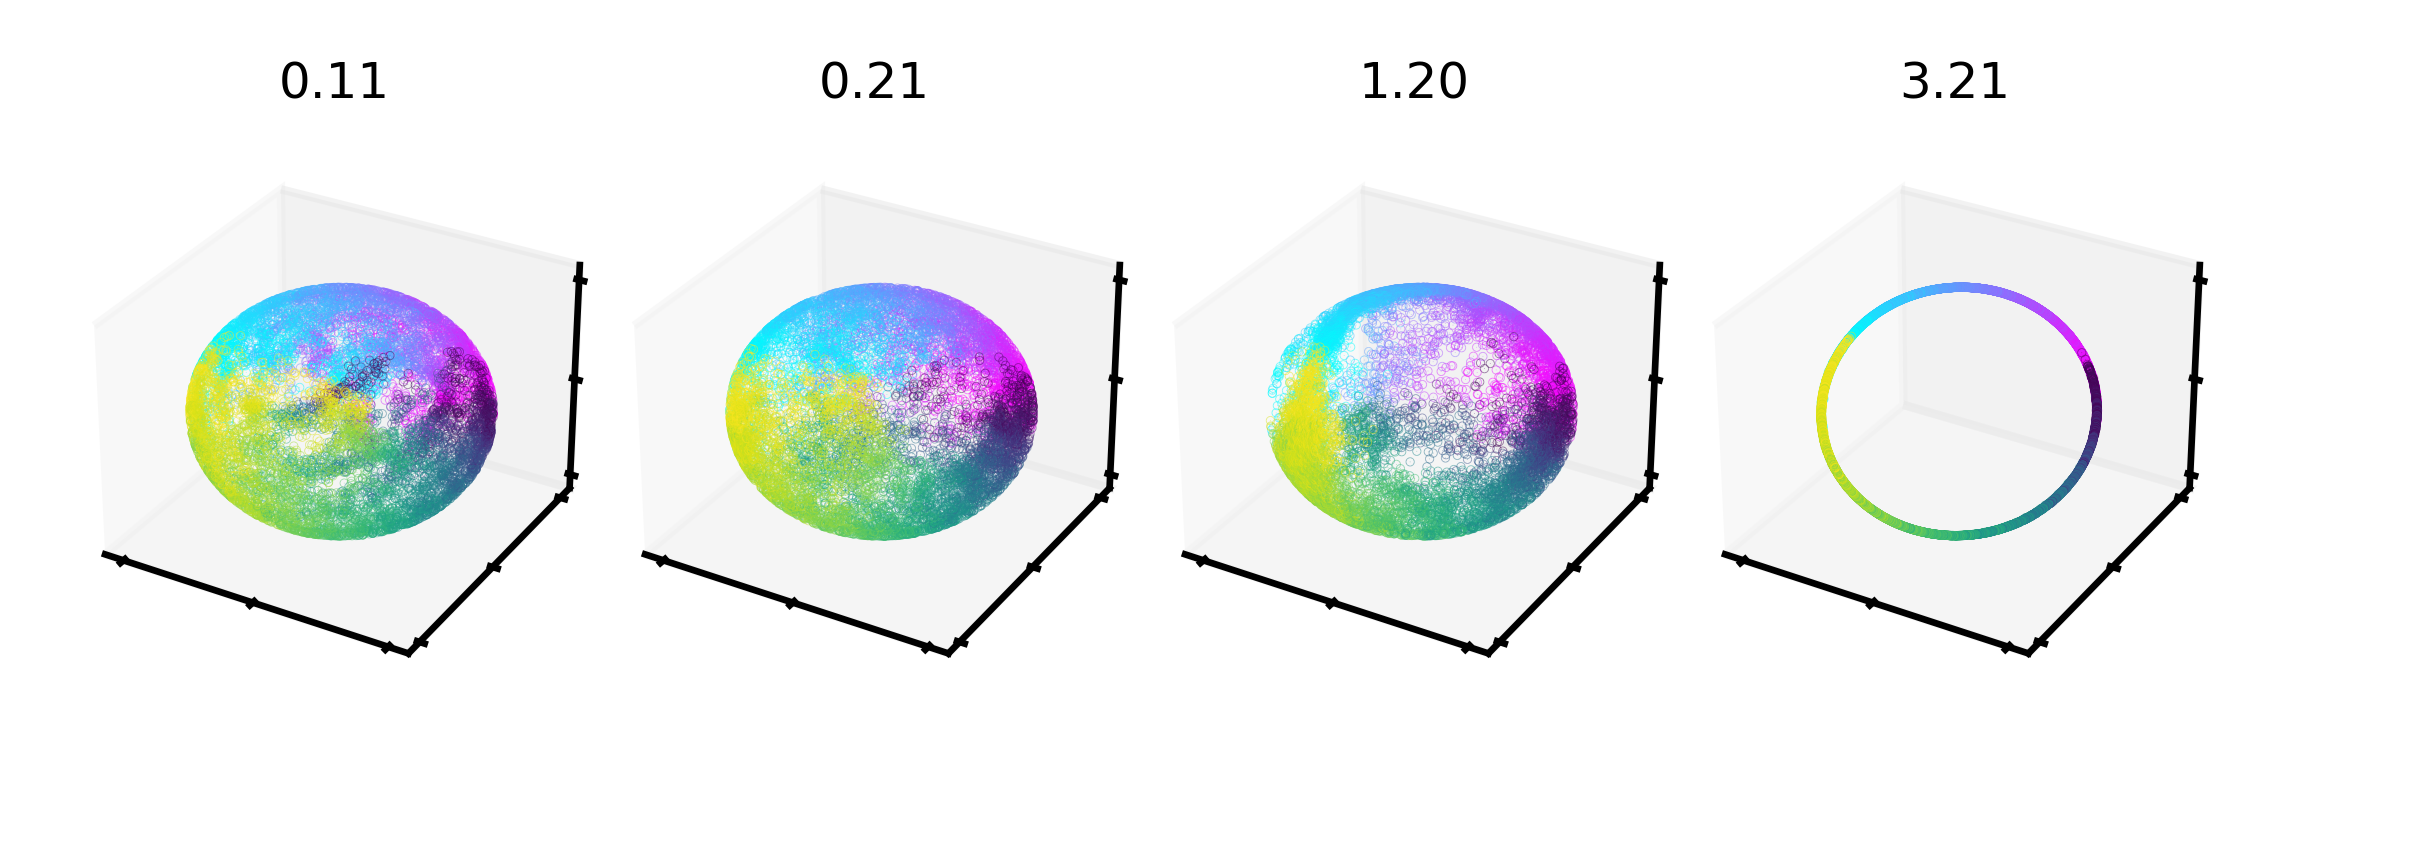

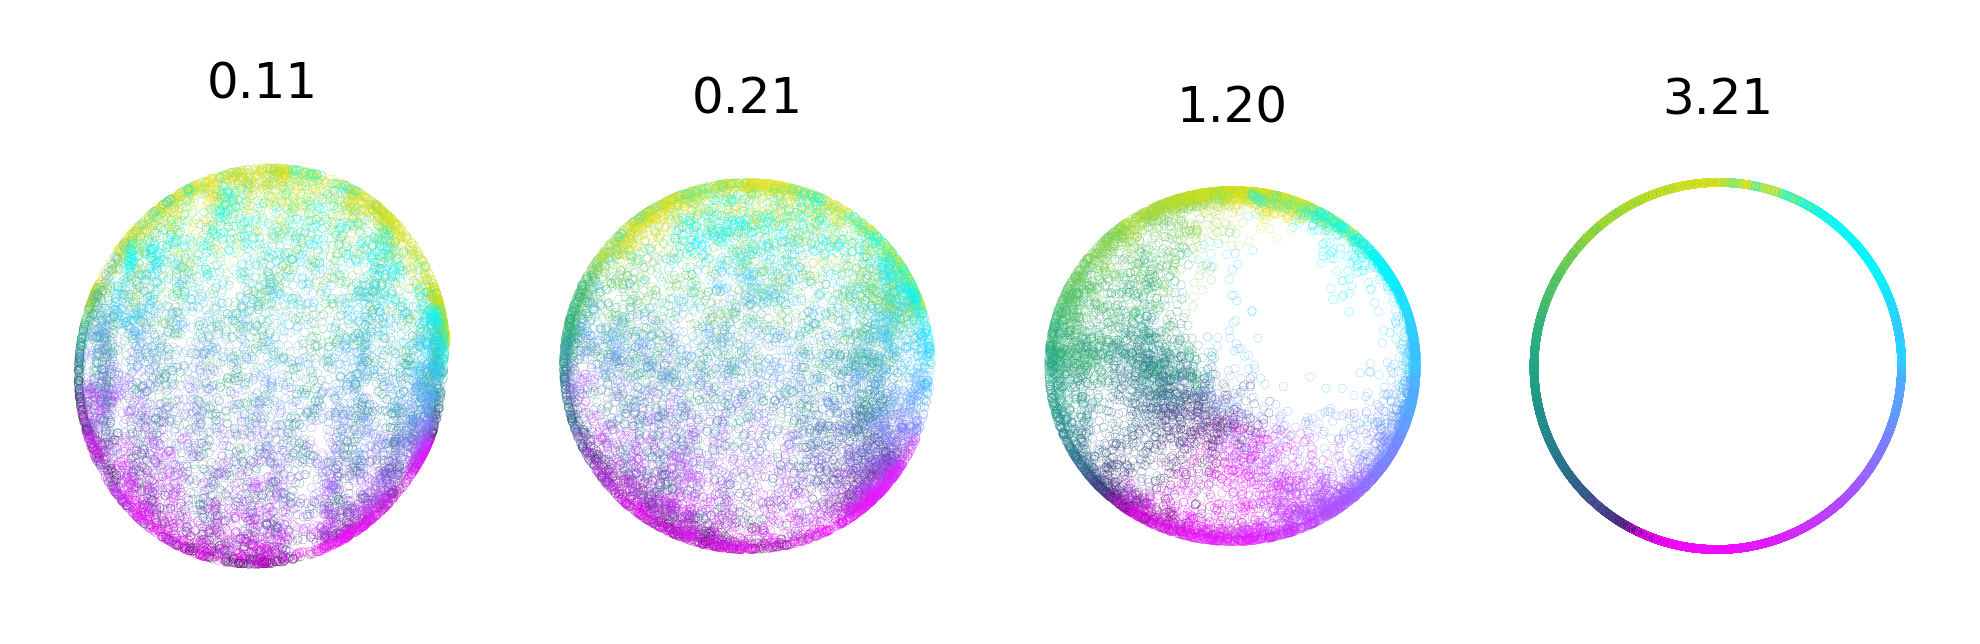

In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt


def _rotate(angle):
    rot = np.eye(2) * np.cos(angle)
    rot[1, 0] = np.sin(angle)
    rot[0, 1] = -rot[1, 0]
    return rot


def scatter(data, index, ax, s=0.01, alpha=0.5, **kwargs):
    mask = index[:, 1] > 0
    ax.scatter(
        *data[mask].T, c=index[mask, 0], s=s, cmap="viridis_r", alpha=alpha, **kwargs
    )
    ax.scatter(
        *data[~mask].T, c=index[~mask, 0], s=s, cmap="cool", alpha=alpha, **kwargs
    )


def plot_across_temperatures(embeddings):
    display(HTML("<h2>3D CEBRA-Time</h2>"))
    fig = plt.figure(figsize=(4, 4), dpi=600)
    for i, args, embedding, data, ica, labels in embeddings.values:
        data = data @ np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
        ax = fig.add_subplot(1, 4, i + 1, projection="3d")
        scatter(data, labels, ax)
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.grid(visible=False)
        ax.set_title("{temperature:.2f}".format(**args), fontsize=6)

    fig.subplots_adjust(left=0, wspace=-0.0)
    plt.show()

    display(HTML("<h2>3D CEBRA-Time with FastICA -> 2D projection</h2>"))
    fig = plt.figure(figsize=(4, 1), dpi=600)
    for i, args, embedding, data, ica, labels in embeddings.values:
        ax = fig.add_subplot(1, 4, i + 1)
        rot = _rotate(np.pi)
        scatter(ica @ rot, labels, ax, s=0.001, alpha=0.9, marker="o")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(visible=False)
        ax.set_aspect("equal")
        ax.axis("off")
        ax.set_title("{temperature:.2f}".format(**args), fontsize=6)

    plt.show()


embeddings = pd.read_hdf("../data/EDFigure2.h5", key="data")
plot_across_temperatures(embeddings)

- Orange line denotes the median and black dots are individual runs (subject consistency: 10 runs with 3 comparisons per rat; run consistency: 10 runs, each compared to 9 remaining runs).

In [2]:
from matplotlib.markers import MarkerStyle
import warnings
import pathlib
import typing
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = pathlib.Path("../data")


def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results


results_temperature = load_results("results_temperature")

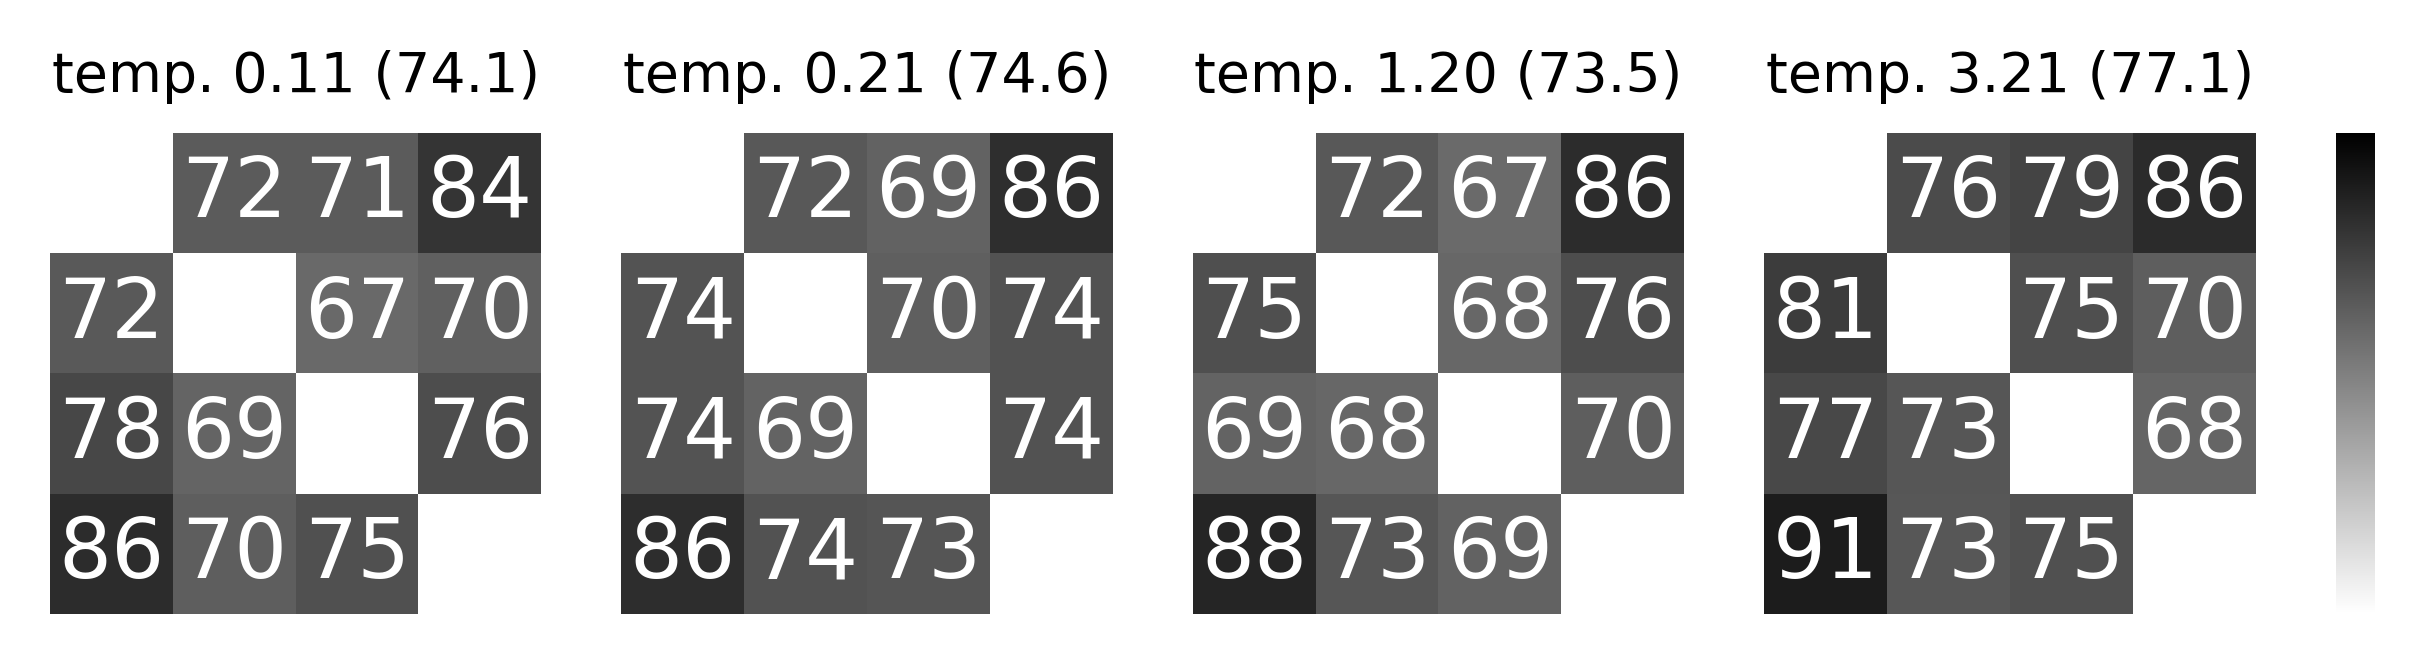

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = False


def to_cfm(values):
    values = np.concatenate(values)
    assert len(values) == 12, len(values)
    c = np.zeros((4, 4))
    c[:] = float("nan")
    c[np.eye(4) == 0] = values
    return c


fig, axs = plt.subplots(
    ncols=5,
    nrows=1,
    figsize=(6, 1.25),
    gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.08]},
    dpi=500,
)

last_ax = axs[-1]

for ax in axs:
    ax.axis("off")

for ax, (key, log) in zip(axs[:-1], sorted(results_temperature.items())):
    cfm = log.pivot_table(
        "train", index=log.index.names, columns=["animal"], aggfunc="mean"
    ).apply(to_cfm, axis=1)
    (cfm,) = cfm.values

    sns.heatmap(
        data=np.minimum(cfm * 100, 99),
        vmin=20,
        vmax=100,
        xticklabels=[],
        yticklabels=[],
        cmap=sns.color_palette("gray_r", as_cmap=True),
        annot=True,
        annot_kws={"fontsize": 12},
        cbar=True if (ax == axs[-2]) else False,
        cbar_ax=last_ax if (ax == axs[-2]) else None,
        ax=ax,
    )
    ax.set_title(f"{key} ({100*np.nanmean(cfm):.1f})", fontsize=8)

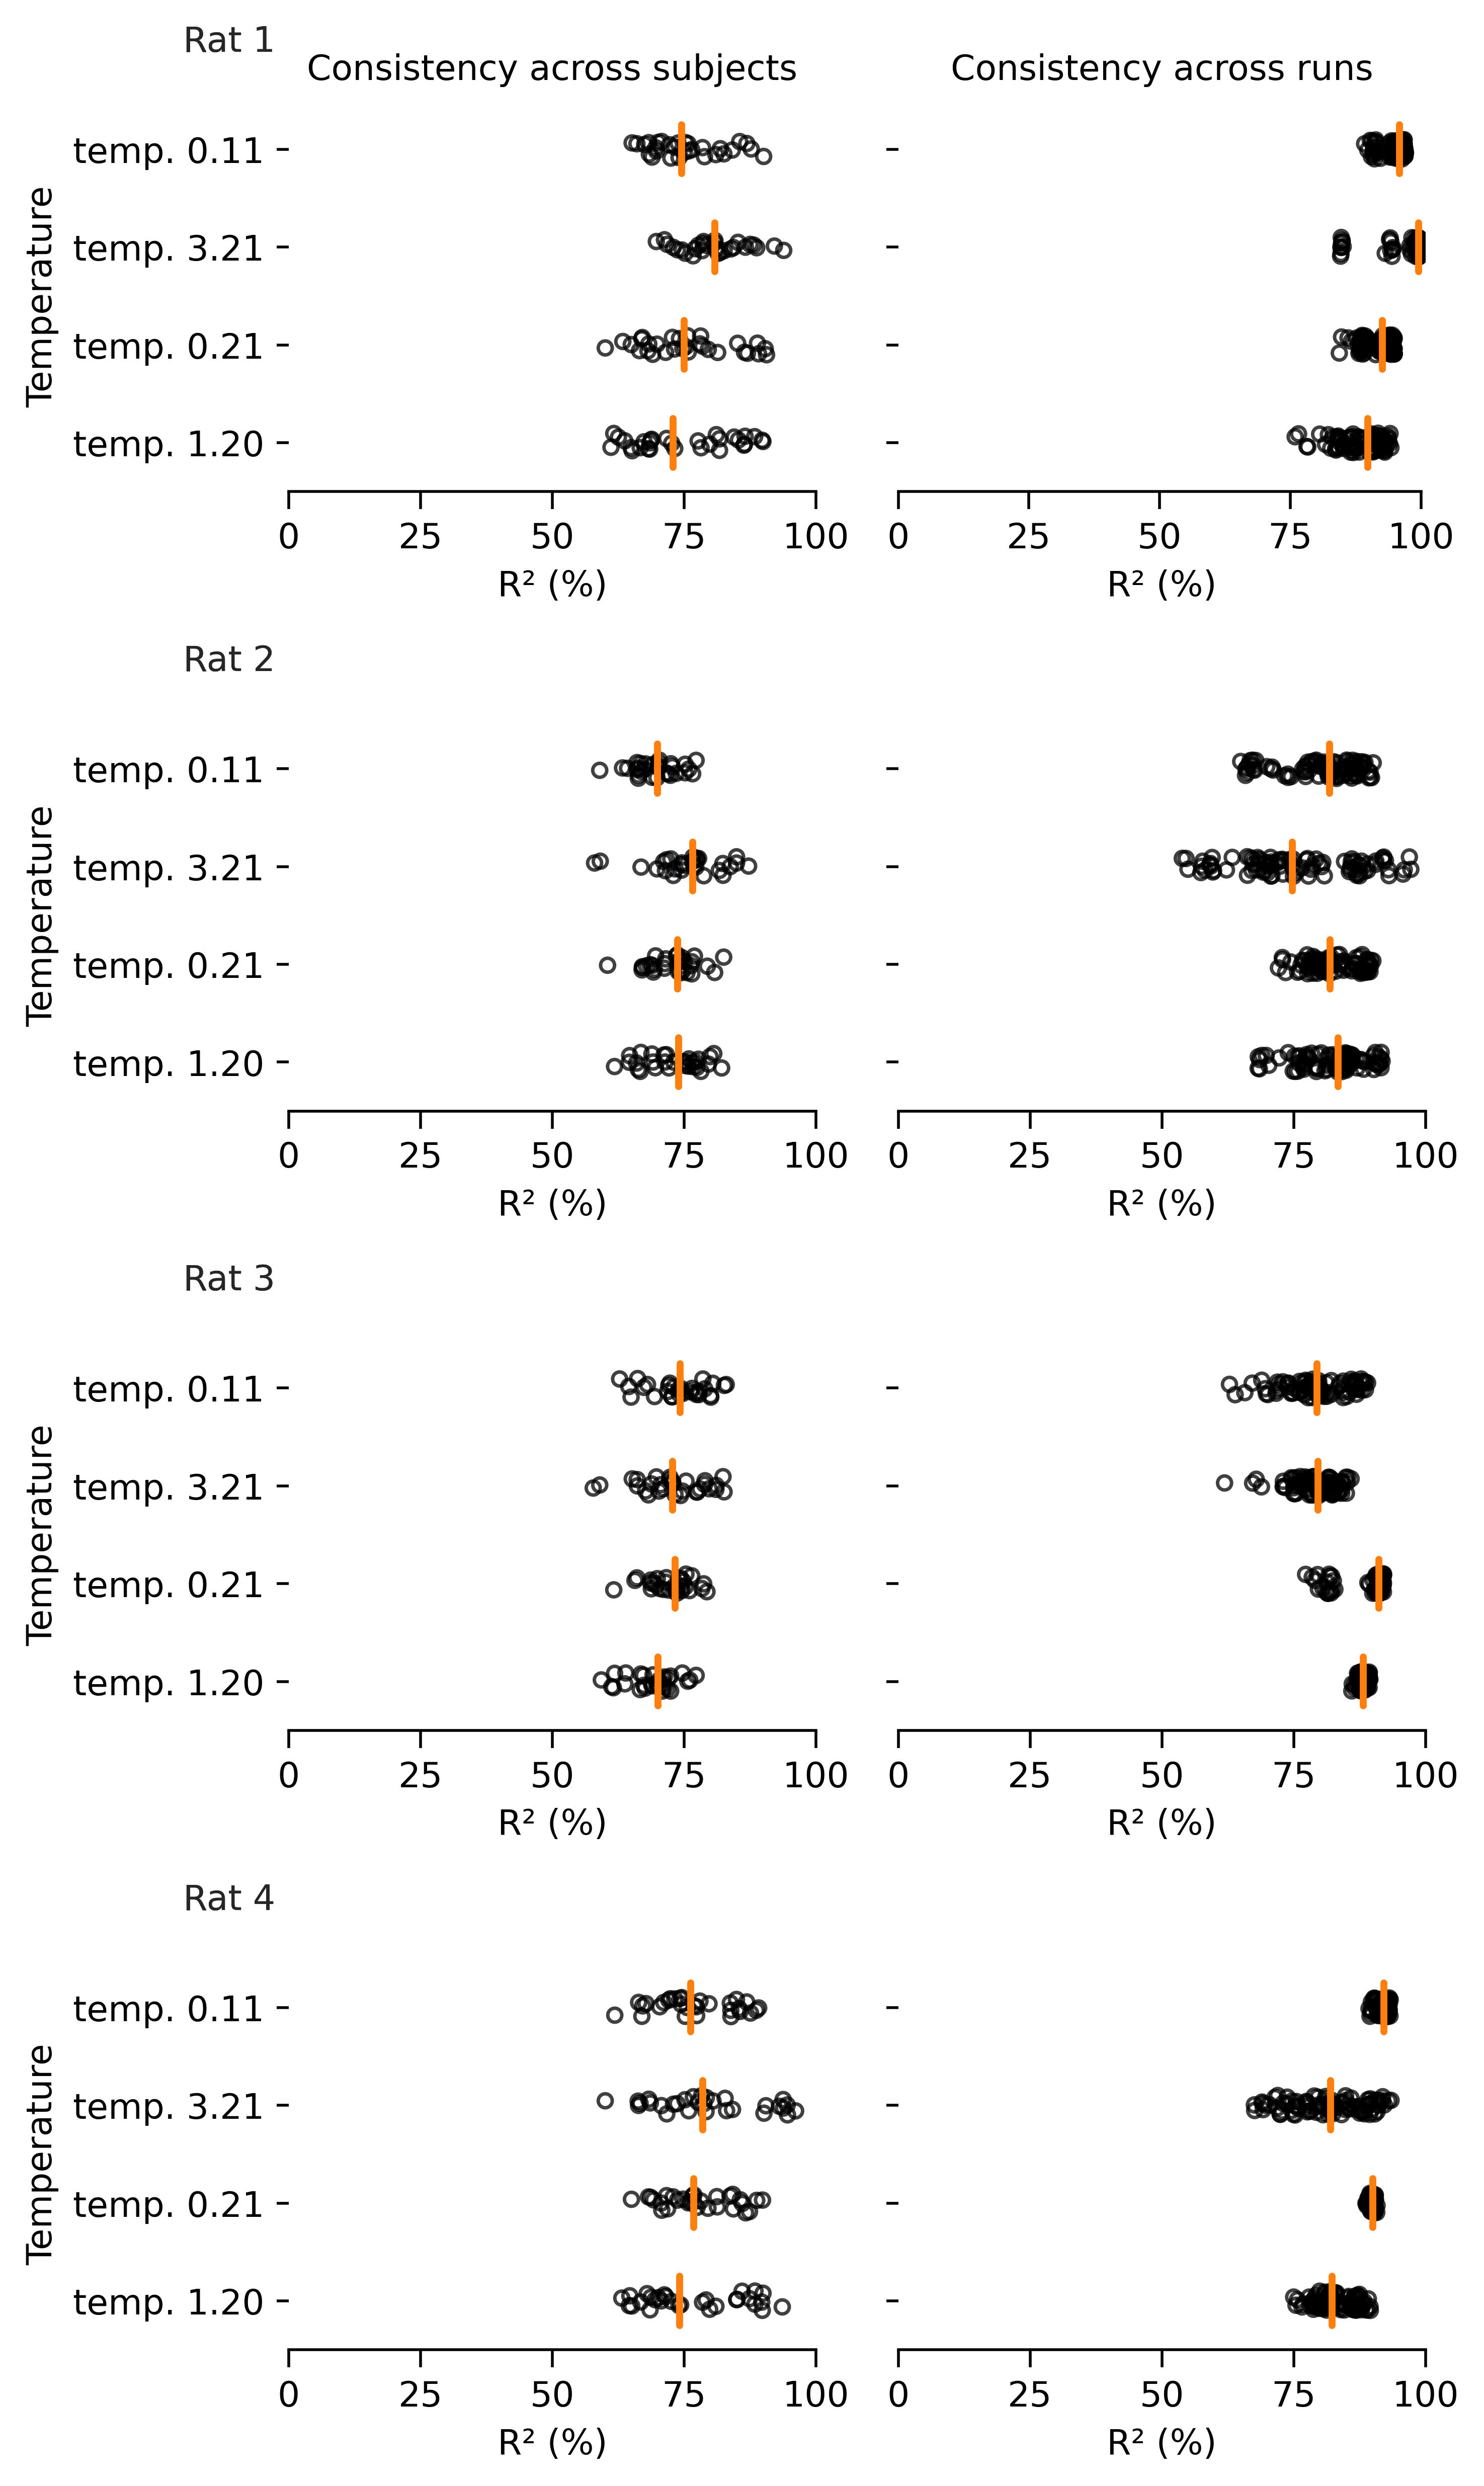

In [4]:
from matplotlib.markers import MarkerStyle
import warnings
import typing
import itertools


def show_boxplot(df, metric, ax, labels=None):

    sns.set_style("white")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        color = "C1"
        sns.boxplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            order=labels,  # unique(labels.values()),
            # hue = "rat",
            width=0.5,
            color="k",
            linewidth=2,
            flierprops=dict(alpha=0.5, markersize=0, marker=".", linewidth=0),
            medianprops=dict(
                c="C1", markersize=0, marker=".", linewidth=2, solid_capstyle="round"
            ),
            whiskerprops=dict(solid_capstyle="butt", linewidth=0),
            # capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
            showbox=False,
            showcaps=False,
            # shownotches = True
            ax=ax,
        )
        marker_style = MarkerStyle("o", "none")

        sns.stripplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            size=4,
            color="black",
            order=labels,
            marker=marker_style,
            linewidth=1,
            ax=ax,
            alpha=0.75,
            jitter=0.1,
            zorder=-1,
        )
        ax.set_ylabel("")
        sns.despine(left=True, bottom=False, ax=ax)
        ax.tick_params(
            axis="x", which="both", bottom=True, top=False, length=5, labelbottom=True
        )
        return ax


def _add_value(df, **kwargs):
    for key, value in kwargs.items():
        df[key] = value
    return df


def join(results):
    return pd.concat([_add_value(df, method=key) for key, df in results.items()])


metadata = [
    ("train", "Consistency across subjects", 100, "R² (%)", [0, 25, 50, 75, 100]),
    (
        "train_run_consistency",
        "Consistency across runs",
        100,
        "R² (%)",
        [0, 25, 50, 75, 100],
    ),
    # Additional metrics, not plotted for space reasons.
    # ("test_total_r2", "Decoding (direction, position)", 100, "R² (%)", [0,25,50,75,100]),
    # ("test_position_error", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20])
]

results_ = join(results_temperature)
fig, axes = plt.subplots(
    4, len(metadata), figsize=(3 * len(metadata), 10), dpi=500, sharey=True
)

label_order = tuple(results_temperature.keys())


def _agg(v):
    return sum(v) / len(v)


for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):

    table = (
        results_.reset_index(drop=True)
        .pivot_table(
            metric,
            index=["animal", "repeat"],
            columns=["method"],
            aggfunc=list,  # lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
        )
        .applymap(
            lambda v: list(
                itertools.chain.from_iterable(v)
                if isinstance(v[0], typing.Iterable)
                else v
            )
        )
        .groupby("animal", level=0)
        .agg(lambda v: np.stack(v).mean(0))
    )

    for animal in table.index:
        df = table.loc[animal].reset_index()
        df.columns = "method", "metric"
        df = df.explode("metric")
        df["metric"] *= scale

        show_boxplot(
            df=df, metric="metric", ax=axes[animal, metric_id], labels=label_order
        )
        ax = axes[animal, metric_id]
        ax.set_xlabel(xlabel)
        ax.set_xticks(xlim)
        ax.spines["bottom"].set_bounds(min(xlim), max(xlim))

        axes[0, metric_id].set_title(metric_name, fontsize=10)
        axes[animal, 0].set_ylabel(f"Temperature")
        axes[animal, 0].text(-20, -1, f"Rat {animal+1}")

plt.tight_layout()
plt.show()